<a href="https://colab.research.google.com/github/kunai-3txk/student-compe/blob/main/PSP_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ref
https://www.kaggle.com/code/kentaro7/beginner-lgbm

https://www.kaggle.com/code/mohammad2012191/lgbm-early-stopping-lb-0-670

# import

In [1]:
!pip install polars
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 44.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import polars as pl
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)



In [3]:
from sklearn.model_selection import KFold, GroupKFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import f1_score

## Config

In [4]:
class paths:
    # kaggle環境ならTrue
    if 'KAGGLE_URL_BASE' in set(os.environ.keys()):
        common_path = "/kaggle/input/amp-parkinsons-disease-progression-prediction"
    
    # colaboratory環境ならTrue
    if 'COLAB_GPU' in set(os.environ.keys()):
        common_path = "/content/drive/MyDrive/PSP/"

    SAMPLE_SUBMISSION = common_path + "sample_submission.csv"
    TRAIN = common_path + "train.csv"
    TRAIN_LABELS = common_path + "train_labels.csv"
    TEST = common_path + "test.csv"
    OUTPUT = common_path

# defnition

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Load Data

In [52]:
targets = pd.read_csv(paths.TRAIN_LABELS)
train_ori  =  reduce_mem_usage(pd.read_csv(paths.TRAIN))
test_ori =  pd.read_csv(paths.TEST)
sample_submission =  pd.read_csv(paths.SAMPLE_SUBMISSION)

In [7]:
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

train = train_ori.copy()
test = test_ori.copy()
train.drop(["fullscreen","hq","music"],axis=1,inplace=True)

#train

In [8]:
#train.describe()
#train.info()

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
def feature_engineer(data):

  data["elapsed_time"].fillna(data["elapsed_time"].mean())
  data["elapsed_time"] = np.log(data["elapsed_time"]).round(3)
  data["elapsed_time"] = data["elapsed_time"].replace([np.inf, -np.inf], np.nan)
  data["elapsed_time"].fillna(2.25,inplace=True)

  le = LabelEncoder()

  data["event_name"] = le.fit_transform(data["event_name"])
  data["name"] = le.fit_transform(data["name"])
  data["page"] = data["page"].fillna(-1)
  data["page"] = data["page"].astype(int)
  data["room_coor_x"].fillna(0,inplace=True)
  data["room_coor_y"].fillna(0,inplace=True)
  data["screen_coor_x"].fillna(0,inplace=True)
  data["screen_coor_y"].fillna(0,inplace=True)
  data["hover_duration"].fillna(0,inplace=True)

  data.reset_index(drop=True)

  KEYS = ['session_id','level_group']
  NUMS = ['elapsed_time','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']
  CATS = ['event_name','name','fqid', 'room_fqid', 'text_fqid']

  data_byn = data.groupby(KEYS)[NUMS].agg(["max","min","mean","std"])
  data_byn.columns = ['_'.join(col) for col in data_byn.columns]
  data_byn = data_byn.reset_index()

  data_byc = data.groupby(KEYS)[CATS].agg('nunique')
  data_byc = data_byc.reset_index()
  #train_byc = train_byc.set_index("session_id")

  ret_data =  data_byn.merge(data_byc,on=['session_id','level_group'])

  ret_data =  ret_data.reset_index(drop=True)
  ret_data = ret_data.set_index("session_id")

  #print('byn shape:',data_byn.shape,'byc shape:',data_byc.shape,'ret_df shape:',ret_data.shape)
  return ret_data

In [11]:
df_train = feature_engineer(train)
print(df_train.shape)
df_train.head()

(35337, 30)


,level_group,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_std,room_coor_x_max,room_coor_x_min,room_coor_x_mean,room_coor_x_std,room_coor_y_max,room_coor_y_min,room_coor_y_mean,room_coor_y_std,screen_coor_x_max,screen_coor_x_min,screen_coor_x_mean,screen_coor_x_std,screen_coor_y_max,screen_coor_y_min,screen_coor_y_mean,screen_coor_y_std,hover_duration_max,hover_duration_min,hover_duration_mean,hover_duration_std,event_name,name,fqid,room_fqid,text_fqid
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,12.180,2.250,11.000733,1.229232,955.5,-1013.5,7.269531,388.166178,416.00,-307.75,-67.50000,126.746080,843.0,0.0,424.0,232.526128,639.0,0.0,362.25,133.609168,7899.0,0.0,115.854546,842.377807,10,3,30,7,17
20090312431273200,13-22,14.057,13.637,13.847905,0.122041,1164.0,-1874.0,-121.687500,601.817476,473.25,-849.00,-151.25000,226.191270,859.0,0.0,413.0,257.076718,659.0,0.0,354.00,134.654423,4750.0,0.0,57.852383,393.094761,10,3,49,12,35
20090312431273200,5-12,13.121,12.308,12.759943,0.231607,1111.0,-808.0,12.804688,337.958386,419.50,-331.00,-51.28125,131.170538,872.0,0.0,404.5,237.050205,640.0,0.0,339.00,162.603835,4183.0,0.0,98.243240,506.186455,10,3,39,11,24
20090312433251036,0-4,12.362,2.250,10.901266,1.601088,934.5,-1112.0,-78.625000,431.685473,441.00,-518.50,-50.18750,151.585043,875.0,0.0,335.0,259.713553,639.0,0.0,346.75,148.604281,5567.0,0.0,79.352516,575.094634,11,4,22,6,11
20090312433251036,13-22,15.155,13.978,14.675087,0.349149,1234.0,-1887.0,-24.750000,475.227565,433.00,-845.00,-115.00000,217.663468,878.0,0.0,372.5,296.259769,657.0,0.0,312.25,194.826328,22351.0,0.0,139.966843,921.308692,11,6,73,16,43


In [12]:
df_test = feature_engineer(test)
print(df_test.shape)
df_test.head()

(9, 30)


,level_group,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_std,room_coor_x_max,room_coor_x_min,room_coor_x_mean,room_coor_x_std,room_coor_y_max,room_coor_y_min,room_coor_y_mean,room_coor_y_std,screen_coor_x_max,screen_coor_x_min,screen_coor_x_mean,screen_coor_x_std,screen_coor_y_max,screen_coor_y_min,screen_coor_y_mean,screen_coor_y_std,hover_duration_max,hover_duration_min,hover_duration_mean,hover_duration_std,event_name,name,fqid,room_fqid,text_fqid
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20090109393214576,0-4,12.496,2.250,11.328029,1.209918,877.958258,-941.617960,37.758431,430.614896,471.968424,-449.577181,-61.855789,142.566482,842.0,0.0,416.321429,262.870027,639.0,0.0,358.542857,131.415502,5168.0,0.0,71.671429,545.436706,11,4,24,6,13
20090109393214576,13-22,15.691,15.564,15.633814,0.037125,1214.941972,-1911.150867,-116.498761,609.691352,431.237769,-908.325270,-206.340018,271.134920,870.0,0.0,407.090444,250.700537,657.0,0.0,368.139932,152.833905,5533.0,0.0,61.489761,433.485426,11,4,52,12,35
20090109393214576,5-12,15.520,12.622,13.958909,1.096596,1135.079457,-952.955767,43.038183,357.332581,345.257661,-533.748174,-38.659617,130.030171,874.0,0.0,426.522388,271.931464,652.0,0.0,323.835821,158.829195,23451.0,0.0,244.729478,1502.572245,11,4,43,12,23
20090312143683264,0-4,12.687,2.250,11.538638,1.205204,945.469667,-979.695385,85.958907,426.824981,401.948788,-438.390890,-105.585713,173.843856,865.0,0.0,462.312883,255.147658,632.0,0.0,387.760736,167.518005,15917.0,0.0,169.319018,1333.020883,11,4,27,7,15
20090312143683264,13-22,14.813,14.331,14.591751,0.142100,1180.913524,-1897.053174,-19.592516,555.144664,476.424326,-855.716733,-184.339970,251.903702,876.0,0.0,440.914718,270.851231,653.0,0.0,385.352132,171.183773,11249.0,0.0,61.806052,515.814534,11,6,55,15,38


In [20]:
FEATURES = [c for c in df_train.columns if c != 'level_group']
print(FEATURES)
ALL_USERS = df_train.index.unique()
print(ALL_USERS)

['elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_std', 'room_coor_x_max', 'room_coor_x_min', 'room_coor_x_mean', 'room_coor_x_std', 'room_coor_y_max', 'room_coor_y_min', 'room_coor_y_mean', 'room_coor_y_std', 'screen_coor_x_max', 'screen_coor_x_min', 'screen_coor_x_mean', 'screen_coor_x_std', 'screen_coor_y_max', 'screen_coor_y_min', 'screen_coor_y_mean', 'screen_coor_y_std', 'hover_duration_max', 'hover_duration_min', 'hover_duration_mean', 'hover_duration_std', 'event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
Int64Index([20090312431273200, 20090312433251036, 20090314121766812,
            20090314363702160, 20090314441803444, 20090315081004164,
            20090315085850788, 20090315101457836, 20090315170769824,
            20090317080721164,
            ...
            22100213081672770, 22100213133089136, 22100215032067016,
            22100215190998610, 22100215241104530, 22100215342220508,
            22100215460321130, 22100217104993650, 2210021

#fit

In [39]:
N_FOLDS = 10

gkf = GroupKFold(n_splits=N_FOLDS)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH N GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df_train, groups=df_train.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = "0-4"
        elif t<=13: grp = "5-12"
        elif t<=22: grp = "13-22"
            
        # TRAIN DATA
        train_x = df_train.iloc[train_index]
        train_x = train_x.loc[train_x['level_group'] == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets['q']==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df_train.iloc[test_index]
        valid_x = valid_x.loc[valid_x['level_group'] == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets['q']==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        model = LGBMRegressor(learning_rate=0.027, \
                    num_leaves=15, \
                    n_estimators=200, \
                    min_child_samples=20, \
                    boosting_type='gbdt',
                    subsample_for_bin=1000,
                    max_depth=-1,
                    colsample_bytree=0.8)
        model.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{i}_{grp}_{t}'] = model
        oof.loc[valid_users, t-1] = model.predict(valid_x[FEATURES])
        
    print()

{'0_0-4_1': LGBMRegressor(colsample_bytree=0.8, learning_rate=0.027, n_estimators=200,
               num_leaves=15, subsample_for_bin=1000),
 '0_0-4_2': LGBMRegressor(colsample_bytree=0.8, learning_rate=0.027, n_estimators=200,
               num_leaves=15, subsample_for_bin=1000),
 '0_0-4_3': LGBMRegressor(colsample_bytree=0.8, learning_rate=0.027, n_estimators=200,
               num_leaves=15, subsample_for_bin=1000),
 '0_5-12_4': LGBMRegressor(colsample_bytree=0.8, learning_rate=0.027, n_estimators=200,
               num_leaves=15, subsample_for_bin=1000),
 '0_5-12_5': LGBMRegressor(colsample_bytree=0.8, learning_rate=0.027, n_estimators=200,
               num_leaves=15, subsample_for_bin=1000),
 '0_5-12_6': LGBMRegressor(colsample_bytree=0.8, learning_rate=0.027, n_estimators=200,
               num_leaves=15, subsample_for_bin=1000),
 '0_5-12_7': LGBMRegressor(colsample_bytree=0.8, learning_rate=0.027, n_estimators=200,
               num_leaves=15, subsample_for_bin=1000),
 '

In [22]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets['q'] == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [23]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

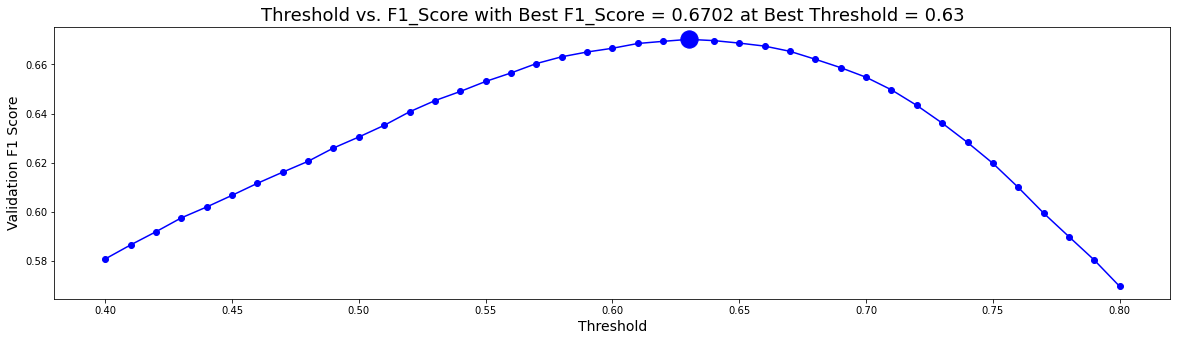

In [24]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.4f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [66]:
def predict(qid,test):
    val = 0
    if qid<=3: grp = "0-4"
    elif qid<=13: grp = "5-12"
    elif qid<=22: grp = "13-22"

    for fold in range(N_FOLDS): ##10
        val += models[f'{fold}_{grp}_{qid}'].predict(test[FEATURES])[0] ##fold->grp_number ,grp->level , qid->question_number
    return val > best_threshold*N_FOLDS

In [68]:
submission = sample_submission.copy()

# FEATURE ENGINEER TEST DATA
df = feature_engineer(test)
#df.shape #(9,30)
#sample_submission.shape #(54,4)


submission['qid'] = sample_submission['session_id'].apply(lambda x: x.split('_')[1][1:]).astype(int)
submission['correct'] = submission['qid'].apply(lambda x: predict(x,df)).astype(int)

,session_id,correct,session_level,qid
0,20090109393214576_q1,0,20090109393214576_0-4,1
1,20090312143683264_q1,0,20090312143683264_0-4,1
2,20090312331414616_q1,0,20090312331414616_0-4,1
3,20090109393214576_q2,1,20090109393214576_0-4,2
4,20090312143683264_q2,1,20090312143683264_0-4,2
5,20090312331414616_q2,1,20090312331414616_0-4,2
6,20090109393214576_q3,1,20090109393214576_0-4,3
7,20090312143683264_q3,1,20090312143683264_0-4,3
8,20090312331414616_q3,1,20090312331414616_0-4,3
9,20090109393214576_q4,0,20090109393214576_5-12,4
